In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import plotly.express as px
from matplotlib import colors
from os import listdir
from os.path import isfile, join
import numpy as np

In [104]:
# product from country exports / total country exports / product world exports / total world exports

# product from country exports -> soy_data
# total country exports -> done
# product world exports -> done 
# total world exports -> done

In [182]:
soy_data = pd.read_csv('https://raw.githubusercontent.com/friedrich-henrique/datasets_soybeans_research/main/soytrade_dataset.csv')
country_exports = pd.read_csv('https://raw.githubusercontent.com/friedrich-henrique/datasets_soybeans_research/main/country_exports.csv')
world_exports = pd.read_csv('https://raw.githubusercontent.com/friedrich-henrique/datasets_soybeans_research/main/world_exports.csv')
soy_exports = pd.read_csv('https://raw.githubusercontent.com/friedrich-henrique/datasets_soybeans_research/main/soy_world_trade.csv')

In [183]:
print(soy_data['Year'].min(), soy_data['Year'].max()) 

1996 2022


In [108]:
# group the soy_data by source country and year, sum the trade_value
soy_country_exports = soy_data.groupby(['Source', 'Year'], as_index=False).sum().loc[:, ['Source', 'Year', 'trade_value']]

In [109]:
# we can start our approach gettin the easier index, the denominator, since it is equal to all countries, 
# we just have to calculate the percantage of soybeans trade relative to all trade for each year.

In [110]:
print(world_exports.size, soy_exports.size) 

270 270


In [184]:
world_exports.head()

,Nomenclature,ReporterISO3,ProductCode,ReporterName,PartnerISO3,PartnerName,Year,TradeFlowName,TradeFlowCode,TradeValue in 1000 USD
0,H1,All,Total,All countries All --- All,WLD,World,1996,Export,6,4.154124e+09
1,H1,All,Total,All countries All --- All,WLD,World,1997,Export,6,4.711246e+09
2,H1,All,Total,All countries All --- All,WLD,World,1998,Export,6,4.768369e+09
3,H1,All,Total,All countries All --- All,WLD,World,1999,Export,6,5.048204e+09
4,H1,All,Total,All countries All --- All,WLD,World,2000,Export,6,5.948860e+09


In [185]:
# merge the two datasets and select only the columns we need
denominator = world_exports.merge(soy_exports, on='Year').loc[:, ['Year', 'TradeValue in 1000 USD_x', 'TradeValue in 1000 USD_y']]
# rename the columns
denominator.columns = ['Year', 'World Exports', 'Soy Exports']
# calculate the percentage
denominator['Share'] = denominator['Soy Exports'] / denominator['World Exports']

denominator.head()

,Year,World Exports,Soy Exports,Share
0,1996,4.154124e+09,8.364485e+06,0.002014
1,1997,4.711246e+09,1.073127e+07,0.002278
2,1998,4.768369e+09,8.897066e+06,0.001866
3,1999,5.048204e+09,7.538839e+06,0.001493
4,2000,5.948860e+09,9.127687e+06,0.001534


In [113]:
# denominator is ready, time to calculate the numerator

country_exports.head()

,Nomenclature,ReporterISO3,ProductCode,ReporterName,PartnerISO3,PartnerName,Year,TradeFlowName,TradeFlowCode,TradeValue in 1000 USD
0,H1,ABW,Total,Aruba,WLD,World,2000,Export,6,172999.090
1,H1,ABW,Total,Aruba,WLD,World,2001,Export,6,148856.140
2,H1,ABW,Total,Aruba,WLD,World,2002,Export,6,128258.862
3,H1,ABW,Total,Aruba,WLD,World,2003,Export,6,82190.500
4,H1,ABW,Total,Aruba,WLD,World,2004,Export,6,79682.025


In [114]:
soy_country_exports.head()

,Source,Year,trade_value
0,ABW,2000,0.162
1,ABW,2003,12.413
2,ABW,2007,0.011
3,ABW,2008,2.925
4,ABW,2009,1.048


In [115]:
# it will be a bit more difficult, since as we can see not all countries have soybeans exports, or there are some years missing on the soybeans dataset
# hence one simple solution is to add the country exports data into the soy_country_exports dataframe, since we do not need to keep track of what data is missing
print (len(soy_country_exports), len(country_exports))

2390 4088


In [116]:
for row in range(len(soy_country_exports)):
    soy_country_exports.loc[row, 'Country Export'] = country_exports.loc[(country_exports['ReporterISO3'] == soy_country_exports.loc[row]['Source']) & (country_exports['Year'] == soy_country_exports.loc[row]['Year']), 'TradeValue in 1000 USD'].values[0]

In [117]:
soy_country_exports.columns = ['Country', 'Year', 'Trade Value', 'Country Export']

soy_country_exports['Share'] = soy_country_exports['Trade Value'] / soy_country_exports['Country Export']

soy_country_exports.head()

,Country,Year,Trade Value,Country Export,Share
0,ABW,2000,0.162,172999.090,9.364211e-07
1,ABW,2003,12.413,82190.500,1.510272e-04
2,ABW,2007,0.011,97892.753,1.123679e-07
3,ABW,2008,2.925,100869.319,2.899792e-05
4,ABW,2009,1.048,135747.078,7.720240e-06


In [118]:
denominator.head()

,Year,World Exports,Soy Exports,Share
0,1996,4.154124e+09,8.364485e+06,0.002014
1,1997,4.711246e+09,1.073127e+07,0.002278
2,1998,4.768369e+09,8.897066e+06,0.001866
3,1999,5.048204e+09,7.538839e+06,0.001493
4,2000,5.948860e+09,9.127687e+06,0.001534


In [119]:
# now we have the numerator and the denominator, we can calculate the index
# this will be done using the soy country exports dataframe , we will retrieve the denominator for the corresponding year. 
# consequently we will have the Ballassa index, since it is just the ratio of these two values

# Merge the two DataFrames based on the "Year" column
soy_country_exports = soy_country_exports.merge(denominator[['Year', 'Share']], on='Year', how='left')

# Rename the "Share" column from the denominator DataFrame
soy_country_exports.rename(columns={'Share_y': 'Denominator', 'Share_x': 'Numerator'}, inplace=True)

soy_country_exports.head()

,Country,Year,Trade Value,Country Export,Numerator,Denominator
0,ABW,2000,0.162,172999.090,9.364211e-07,0.001534
1,ABW,2003,12.413,82190.500,1.510272e-04,0.002173
2,ABW,2007,0.011,97892.753,1.123679e-07,0.001736
3,ABW,2008,2.925,100869.319,2.899792e-05,0.002311
4,ABW,2009,1.048,135747.078,7.720240e-06,0.002784


In [132]:
# just a quick check to see if the denominator data is equal for the entire year 
soy_country_exports.loc[(soy_country_exports['Year'] == 2018), :].head()

,Country,Year,Trade Value,Country Export,Numerator,Denominator
6,AFG,2018,2.309,8.752414e+05,2.638129e-06,0.003213
8,AGO,2018,11.928,4.066472e+07,2.933255e-07,0.003213
19,ARE,2018,0.569,1.733842e+08,3.281729e-09,0.003213
45,ARG,2018,1386599.732,6.155836e+07,2.252496e-02,0.003213
71,AUS,2018,2293.799,2.565653e+08,8.940411e-06,0.003213


In [133]:
soy_country_exports['Balassa Index'] = soy_country_exports['Numerator'] / soy_country_exports['Denominator']

In [134]:
soy_country_exports.sort_values(by='Balassa Index', ascending=False).head()

,Country,Year,Trade Value,Country Export,Numerator,Denominator,Balassa Index
1810,PRY,1999,307134.810,740768.872,0.414616,0.001493,277.637901
1809,PRY,1998,440314.828,1014102.656,0.434192,0.001866,232.704329
1822,PRY,2011,2294318.165,7776442.112,0.295034,0.002651,111.271761
1816,PRY,2005,562992.041,3152567.667,0.178582,0.001606,111.225319
1815,PRY,2004,573242.760,2874456.410,0.199426,0.001802,110.685137


In [173]:
def get_top_balassa_index(df, top=10):
    return df.groupby('Country').mean().sort_values(by='Balassa Index', ascending=False).head(top).index.values

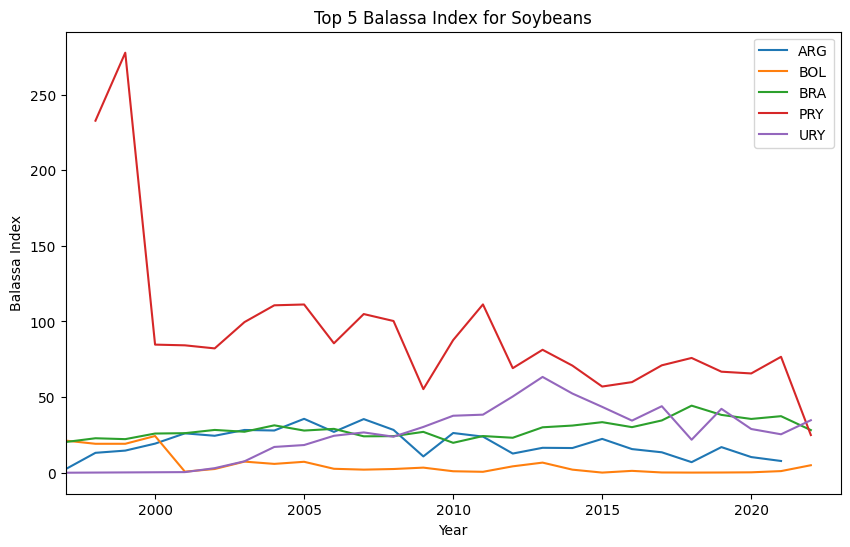

In [181]:
number = 5

top = get_top_balassa_index(soy_country_exports, top=number)

plt.figure(figsize=(10, 6))

# Group the DataFrame by country
grouped_df = soy_country_exports.loc[soy_country_exports['Country'].isin(top), :].groupby('Country')

# Create a line chart for each country
for country, data in grouped_df:
    plt.plot(data['Year'], data['Balassa Index'], label=country)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Balassa Index')
plt.title(f'Top {number} Balassa Index for Soybeans')

plt.xlim(soy_country_exports['Year'].min() + 1, soy_country_exports['Year'].max() + 1)

# Add legend
plt.legend()

# Show the chart
plt.show()


fig = px.line(soy_country_exports.loc[soy_country_exports['Country'].isin(top), :], x='Year', y='Balassa Index', color='Country', symbol="Country")

# Adjust the figure layout
fig.update_layout(
    width=800,  # Adjust the width as desired
    height=600,  # Adjust the height as desired
)

fig.update_xaxes(range=[soy_country_exports['Year'].min(), soy_country_exports['Year'].max() + 2])  # Assumes the data is sorted by year
fig.show()